In [1]:
!git clone https://github.com/nagi1995/tensorflow-yolov4-tflite

Cloning into 'tensorflow-yolov4-tflite'...
remote: Enumerating objects: 913, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 913 (delta 13), reused 0 (delta 0), pack-reused 855
Receiving objects: 100% (913/913), 291.31 MiB | 20.63 MiB/s, done.
Resolving deltas: 100% (431/431), done.
Checking out files: 100% (150/150), done.


In [2]:
%cd tensorflow-yolov4-tflite

/content/tensorflow-yolov4-tflite


In [3]:
import os
os.getcwd()

'/content/tensorflow-yolov4-tflite'

In [11]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
from absl import app, flags, logging
from absl.flags import FLAGS
import core.utils as utils
from core.yolov4 import filter_boxes
from tensorflow.python.saved_model import tag_constants
import cv2
import numpy as np
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from math import ceil
from time import time
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    from google.colab.patches import cv2_imshow

In [9]:
IN_COLAB

True

In [5]:
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
FLAGS = {}
FLAGS["tiny"] = True
FLAGS["model"] = "yolov4"

In [15]:
def detect_tiles():
    '''
    This functions prints
    the time taken for 
    object detection in tensorflow.
    '''
    score = .25
    iou = 0.5
    input_size = 416
    image_path = "./test_images/00000032.png"
    weights_path = "./checkpoints/yolov4-tiny-custom_best-416"
    im_name = image_path.split("/")[-1]
    # ext = im_name.split(".")[-1]
    start = time()
    original_image = cv2.imread(image_path)
    h, w, _ = original_image.shape
    h_new = ceil(h/input_size) * input_size
    w_new = ceil(w/input_size) * input_size
    # scaled_h = h_new/h
    # scaled_w = w_new/w
    resized_image = cv2.resize(original_image, (w_new, h_new), cv2.INTER_LINEAR)
    
    col_list = []
    for i in range(h_new//input_size):
        row_list = []
        for j in range(w_new//input_size):
            tiled_image_original = resized_image[i*input_size : (i+1)*input_size, j*input_size : (j+1)*input_size, :] 
            tiled_image = tiled_image_original / 255.
            tiled_image = np.asarray(tiled_image).astype(np.float32)
            
            saved_model_loaded = tf.saved_model.load(weights_path, tags=[tag_constants.SERVING])
            infer = saved_model_loaded.signatures['serving_default']
            batch_data = tf.constant([tiled_image])
            pred_bbox = infer(batch_data)
            for key, value in pred_bbox.items():
                boxes = value[:, :, 0:4]
                pred_conf = value[:, :, 4:]
            
            boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
                boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
                scores=tf.reshape(pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
                max_output_size_per_class=50,
                max_total_size=50,
                iou_threshold=iou,
                score_threshold=score)
            pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]
            row_list.append(utils.draw_bbox(tiled_image_original, pred_bbox))
        col_list.append(cv2.hconcat(row_list))
    scaled_image = cv2.vconcat(col_list)
    reconstructed_image = cv2.resize(scaled_image, (w, h), interpolation = cv2.INTER_AREA)
    end = time()
    cv2_imshow(reconstructed_image)
    print("time taken: ", end-start)

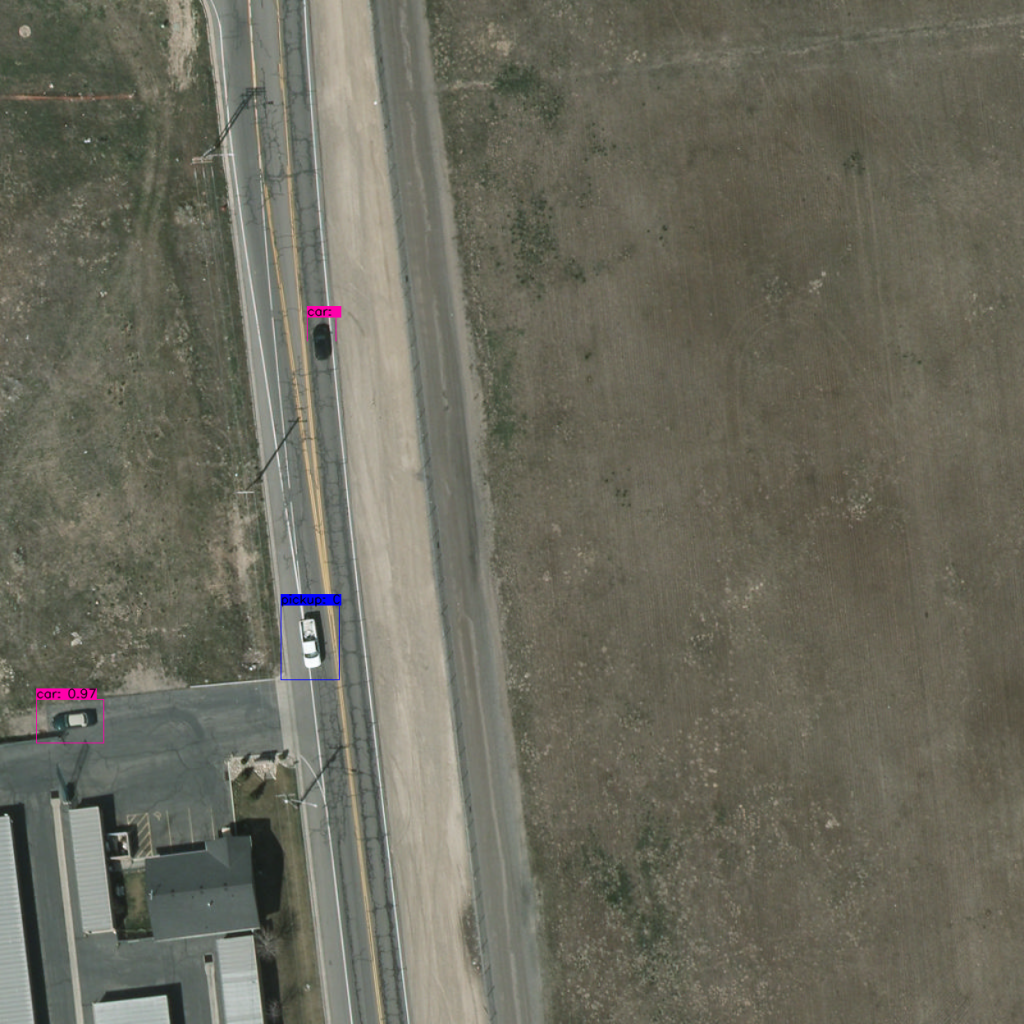

time taken:  63.16457939147949


In [16]:
detect_tiles()

In [13]:
def detect_tiles_lite():
    '''
    This functions prints
    the time taken for 
    object detection in 
    tensorflow lite.
    '''
    score = .25
    iou = 0.5
    input_size = 416
    image_path = "./test_images/00000032.png"
    weights_path = "./checkpoints/yolov4tiny-custom_best-416-tflite-fp16.tflite"
    
    interpreter = tf.lite.Interpreter(model_path=weights_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    
    im_name = image_path.split("/")[-1]
    # ext = im_name.split(".")[-1]
    start = time()
    original_image = cv2.imread(image_path)
    h, w, _ = original_image.shape
    h_new = ceil(h/input_size) * input_size
    w_new = ceil(w/input_size) * input_size
    
    # scaled_h = h_new/h
    # scaled_w = w_new/w
    resized_image = cv2.resize(original_image, (w_new, h_new), cv2.INTER_LINEAR)
    
    col_list = []
    for i in range(h_new//input_size):
        row_list = []
        for j in range(w_new//input_size):
            tiled_image_original = resized_image[i*input_size : (i+1)*input_size, j*input_size : (j+1)*input_size, :] 
            tiled_image = tiled_image_original / 255.
            tiled_image = np.asarray(tiled_image).astype(np.float32)
            
            interpreter.set_tensor(input_details[0]['index'], [tiled_image])
            interpreter.invoke()
            pred = [interpreter.get_tensor(output_details[i]['index']) for i in range(len(output_details))]
            boxes, pred_conf = filter_boxes(pred[0], pred[1], score_threshold=0.25, input_shape=tf.constant([input_size, input_size]))
            
            boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
                boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
                scores=tf.reshape(pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
                max_output_size_per_class=50,
                max_total_size=50,
                iou_threshold=iou,
                score_threshold=score)
            pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]
            row_list.append(utils.draw_bbox(tiled_image_original, pred_bbox))
        col_list.append(cv2.hconcat(row_list))
    scaled_image = cv2.vconcat(col_list)
    reconstructed_image = cv2.resize(scaled_image, (w, h), interpolation = cv2.INTER_AREA)
    end = time()
    cv2_imshow(reconstructed_image)
    print("time taken:", end-start)

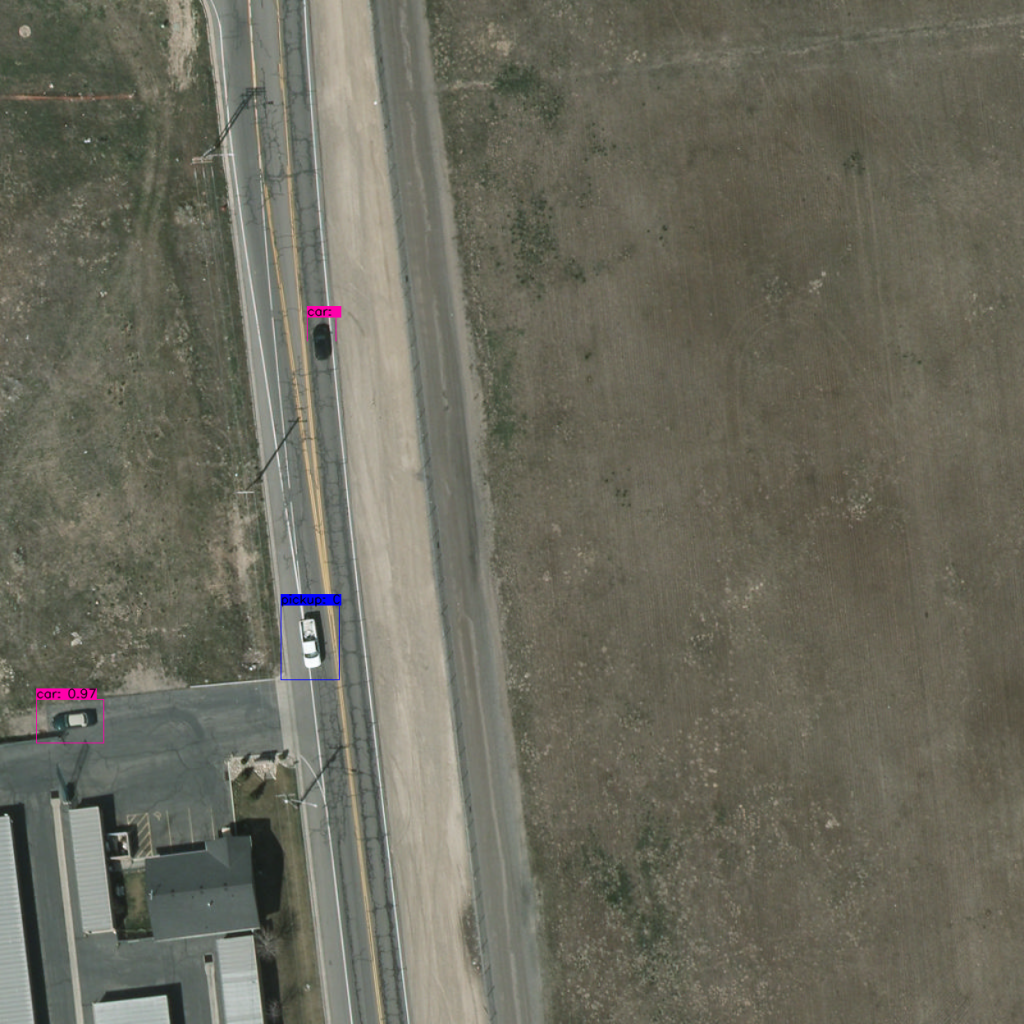

time taken: 1.7377662658691406


In [14]:
#%%time
detect_tiles_lite()